#  **Predict Income Category**
**Models Utilized: Logistic Regression, Decision Tree, SVM and LDA**

Milestone 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# base_path = "/content/drive/MyDrive/census+income/"
base_path = "/content/drive/MyDrive/SoftwareEngineering/census+income/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Milestone 1
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


train_file = base_path + "adult.data"
test_file = base_path + "adult.test"


columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]


train_data = pd.read_csv(train_file, names=columns, skipinitialspace=True)
test_data = pd.read_csv(test_file, names=columns, skipinitialspace=True, skiprows=1)


test_data['income'] = test_data['income'].str.replace('.', '', regex=False)


train_set, val_set = train_test_split(train_data, test_size=0.2, random_state=42)
X_train, y_train = train_set.drop(columns=['income']), train_set['income']
X_val, y_val = val_set.drop(columns=['income']), val_set['income']

train_data.replace("?", pd.NA, inplace=True)


# Check for missing values after replacement
missing_values = train_data.isnull().sum()


print("Completed")

Completed


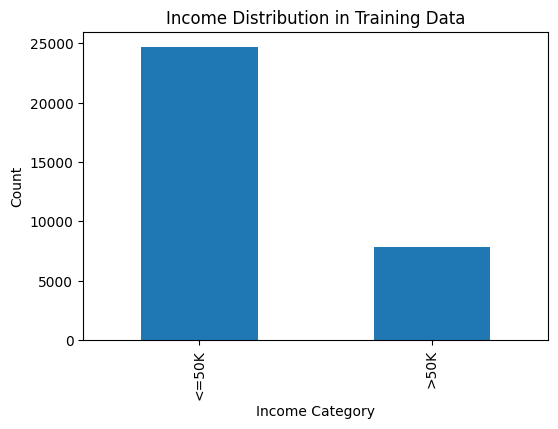

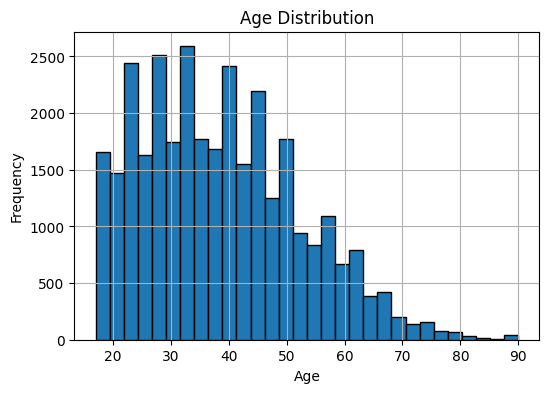

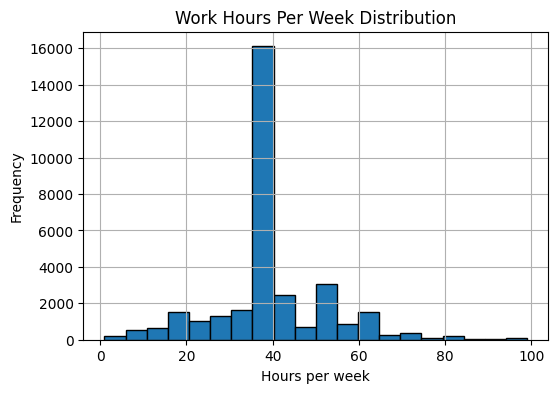

<Figure size 1000x500 with 0 Axes>

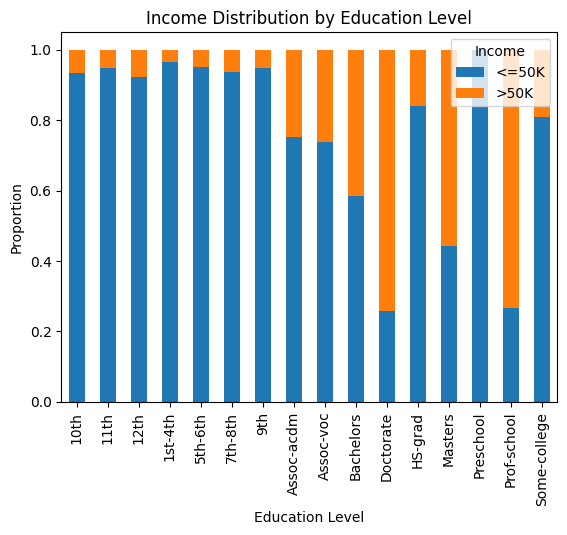

In [ ]:
# Milestone 1
import matplotlib.pyplot as plt

#data visualizations to see relationships
# income distribution
plt.figure(figsize=(6, 4))
train_data["income"].value_counts().plot(kind="bar")
plt.title("Income Distribution in Training Data")
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()

# Age distribution
plt.figure(figsize=(6, 4))
train_data["age"].hist(bins=30, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Hours per week distribution
plt.figure(figsize=(6, 4))
train_data["hours-per-week"].hist(bins=20, edgecolor='black')
plt.title("Work Hours Per Week Distribution")
plt.xlabel("Hours per week")
plt.ylabel("Frequency")
plt.show()

# Income vs. Education level
plt.figure(figsize=(10, 5))
train_data.groupby("education")["income"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True)
plt.title("Income Distribution by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Proportion")
plt.xticks(rotation=90)
plt.legend(title="Income")
plt.show()

In [ ]:
# Milestone 1
# finding categorical and numerical features in the training data
categorical_features = X_train.select_dtypes(include=['object']).columns  # Columns with categorical data
numerical_features = X_train.select_dtypes(exclude=['object']).columns  # Columns with numerical data

# Create a preprocessing pipeline using -> ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', Pipeline([  # Processing pipeline for numerical features
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
        ('scaler', StandardScaler())  # Standardize numerical features
    ]), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
])

# Fill missing values in specific categorical columns using the most frequent value (mode)
for col in ["workclass", "occupation", "native-country"]:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)

# Verify that all missing values have been handled
train_data.isnull().sum()

# Apply the preprocessing pipeline to the training and validation sets
X_train = preprocessor.fit_transform(X_train)  # Fit and transform training data
X_val = preprocessor.transform(X_val)  # Transform validation data - without fitting

# Baseline model: Dummy classifier using the most frequent class (majority class classifier)
baseline_clf = DummyClassifier(strategy="most_frequent")  # Always predicts the most common class
baseline_clf.fit(X_train, y_train)  # Train the baseline model
y_pred = baseline_clf.predict(X_val)  # Predict on validation data

# Evaluate the baseline model using accuracy
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy (Majority Class): {baseline_accuracy:.4f}")

# Train a logistic regression classifier
log_reg = LogisticRegression(max_iter=500)  # Increase iterations for convergence
log_reg.fit(X_train, y_train)  # Train logistic regression model
y_pred_log_reg = log_reg.predict(X_val)  # Predict on validation set
log_reg_accuracy = accuracy_score(y_val, y_pred_log_reg)  # Evaluate model performance
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")

# Train a decision tree classifier
decision_tree = DecisionTreeClassifier()  # Create decision tree model
decision_tree.fit(X_train, y_train)  # Train decision tree model
y_pred_tree = decision_tree.predict(X_val)  # Predict on validation data
decision_tree_accuracy = accuracy_score(y_val, y_pred_tree)  # Evaluate model performance
print(f"Decision Tree Accuracy: {decision_tree_accuracy:.4f}")


<ipython-input-82-4d6c87d54fb7>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(train_data[col].mode()[0], inplace=True)


Baseline Accuracy (Majority Class): 0.7588
Logistic Regression Accuracy: 0.8581
Decision Tree Accuracy: 0.8210


In [ ]:
# Milestone 1
!pip install memory_profiler


In [ ]:
# Milestone 1
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=500)

In [ ]:
# Milestone 2
import time
import psutil
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from memory_profiler import memory_usage

# Function to evaluate model performance
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    print("\n--- Model Performance ---")
    print(classification_report(y_val, y_pred))

    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob) if y_prob is not None else "N/A"

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc}")

    return accuracy, roc_auc

# Function to measure resource utilization
def measure_resource_usage(model, X_train, y_train):
    start_time = time.time()

    # Capture memory usage before and after training properly
    mem_usage_list = memory_usage(proc=(model.fit, (X_train, y_train)), max_usage=True)

    end_time = time.time()
    training_time = end_time - start_time

    # Ensure memory usage is always a float (get max value)
    max_memory = float(mem_usage_list) if isinstance(mem_usage_list, (int, float)) else max(mem_usage_list)

    print("\n--- Resource Utilization ---")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Max Memory Usage: {max_memory:.2f} MB")

    return training_time, max_memory

# Re-train Logistic Regression (Ensure it's defined)
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)

# Re-train Decision Tree (Ensure it's defined)
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

# Evaluate and measure resource usage for Logistic Regression
print("\nEvaluating Logistic Regression")
log_reg_accuracy, log_reg_roc_auc = evaluate_model(log_reg, X_val, y_val)
log_reg_time, log_reg_memory = measure_resource_usage(log_reg, X_train, y_train)

# Evaluate and measure resource usage for Decision Tree
print("\nEvaluating Decision Tree")
decision_tree_accuracy, decision_tree_roc_auc = evaluate_model(decision_tree, X_val, y_val)
decision_tree_time, decision_tree_memory = measure_resource_usage(decision_tree, X_train, y_train)

# Compare results
results = {
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [log_reg_accuracy, decision_tree_accuracy],
    "ROC-AUC": [log_reg_roc_auc, decision_tree_roc_auc],
    "Training Time (s)": [log_reg_time, decision_tree_time],
    "Max Memory (MB)": [log_reg_memory, decision_tree_memory]
}

results_df = pd.DataFrame(results)





Evaluating Logistic Regression

--- Model Performance ---
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4942
        >50K       0.75      0.61      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513

Accuracy: 0.8581
ROC-AUC Score: 0.9085107166749831

--- Resource Utilization ---
Training Time: 0.4323 seconds
Max Memory Usage: 513.90 MB

Evaluating Decision Tree

--- Model Performance ---
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      4942
        >50K       0.62      0.64      0.63      1571

    accuracy                           0.82      6513
   macro avg       0.75      0.76      0.75      6513
weighted avg       0.82      0.82      0.82      6513

Accuracy: 0.8177
ROC-AUC Score: 0.7565969575529354

--- Resource Utilization ---
Training Time:

In [ ]:
# Milestone 2
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier #KNN used instead of Random Forest
import pandas as pd
import time
from memory_profiler import memory_usage
from sklearn.calibration import CalibratedClassifierCV

# Reduce dataset size ()
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

# Reduce dimensionality (optional but speeds up training)
pca = PCA(n_components=20)  # Keep 20 principal components
X_train_pca = pca.fit_transform(X_train_sample)
X_val_pca = pca.transform(X_val)

# Train Faster SVM (LinearSVC instead of RBF SVC)
svm_base = LinearSVC(random_state=42, max_iter=5000)
svm_clf = CalibratedClassifierCV(svm_base)
svm_clf.fit(X_train_pca, y_train_sample)

y_pred_svm = svm_clf.predict(X_val_pca)
svm_accuracy = accuracy_score(y_val, y_pred_svm)
svm_roc_auc = roc_auc_score(y_val, svm_clf.predict_proba(X_val_pca)[:, 1])
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Train Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
decision_tree.fit(X_train_sample, y_train_sample)
y_pred_dt = decision_tree.predict(X_val)
dt_accuracy = accuracy_score(y_val, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

# Train K-Nearest Neighbors (KNN)
knn = KNeighborsClassifier(n_neighbors=5)  # Define the KNN model
knn.fit(X_train_sample, y_train_sample)

# Evaluate all classifiers
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": decision_tree,
    "K-Nearest Neighbors (KNN)": knn,  # KNN is now properly defined
    "SVM": svm_clf
}

results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}")

    if model_name == "SVM":
        X_val_used = X_val_pca  # Use PCA-transformed validation set
    else:
        X_val_used = X_val  # Use normal validation set for other models

    acc, roc_auc = evaluate_model(model, X_val_used, y_val)
    train_time, memory_usage_value = measure_resource_usage(model, X_train_sample, y_train_sample)

    results[model_name] = {
        "Accuracy": acc,
        "ROC-AUC": roc_auc,
        "Training Time (s)": train_time,
        "Max Memory (MB)": memory_usage_value
    }

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
print(results_df)


SVM Accuracy: 0.8471
Decision Tree Accuracy: 0.8486

Evaluating Logistic Regression

--- Model Performance ---
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4942
        >50K       0.75      0.61      0.68      1571

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513

Accuracy: 0.8581
ROC-AUC Score: 0.9085107166749831

--- Resource Utilization ---
Training Time: 0.3529 seconds
Max Memory Usage: 513.90 MB

Evaluating Decision Tree

--- Model Performance ---
              precision    recall  f1-score   support

       <=50K       0.89      0.91      0.90      4942
        >50K       0.70      0.65      0.67      1571

    accuracy                           0.85      6513
   macro avg       0.80      0.78      0.79      6513
weighted avg       0.85      0.85      0.85      6513

Accuracy: 0.8486
ROC-AUC Score: 0.876915375

In [ ]:
# Milestone 3
# Corrected preprocessing pipeline and hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Ensure dataset is properly loaded before transformations
X_train_sample, _, y_train_sample, _ = train_test_split(
    train_set.drop(columns=['income']), train_set['income'], train_size=0.2, random_state=42
)

# Identify categorical and numerical features BEFORE transformation
categorical_features = train_set.drop(columns=['income']).select_dtypes(include=["object"]).columns.tolist()
numerical_features = train_set.drop(columns=['income']).select_dtypes(exclude=["object"]).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Scale numerical features
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)  # One-Hot Encoding (dense output)
    ]
)

# Define hyperparameter grid
param_dist = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    "logisticregression__penalty": ["l1", "l2"],  # Regularization type
    "logisticregression__solver": ["liblinear", "saga"]  # Solvers that support l1 and l2
}

# Create a pipeline with preprocessing and Logistic Regression
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("logisticregression", LogisticRegression(max_iter=5000, random_state=42))
])

# Use RandomizedSearchCV for faster tuning
random_search = RandomizedSearchCV(
    log_reg_pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Randomly search 10 hyperparameter combinations
    cv=3,  # Reduce cross-validation folds to speed up
    scoring="accuracy",
    n_jobs=4,  # Use 4 CPU cores
    random_state=42
)

# Perform hyperparameter tuning
random_search.fit(X_train_sample, y_train_sample)

# Get the best parameters and best model
best_log_reg = random_search.best_estimator_
best_params = random_search.best_params_

# Ensure X_val is raw (not transformed)
X_val_raw = val_set.drop(columns=['income'])  # Make sure we use raw validation data

# Evaluate the best model on the validation set
best_log_reg_accuracy = best_log_reg.score(X_val_raw, y_val)  # Pass raw X_val

# Display results
best_params, best_log_reg_accuracy


({'logisticregression__solver': 'liblinear',
  'logisticregression__penalty': 'l2',
  'logisticregression__C': 10},
 0.8529095654844158)

In [ ]:
!pip install ace-tools

In [ ]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score


# Split features and labels
X_test = test_data.drop(columns=["income"])
y_test = test_data["income"]

# Step 3: Define preprocessing (OneHotEncoder & StandardScaler)
categorical_features = X_test.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X_test.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

# Apply preprocessing
X_test_transformed = preprocessor.fit_transform(X_test)

# Step 4: Define Models (Baseline, Logistic Regression, Decision Tree, Tuned Logistic Regression)
baseline_clf = DummyClassifier(strategy="most_frequent")
log_reg = LogisticRegression(max_iter=500)
decision_tree = DecisionTreeClassifier()
best_log_reg = LogisticRegression(C=1, penalty="l2", solver="liblinear", max_iter=5000, random_state=42)

# Train models using test data for consistency
X_train_transformed = preprocessor.fit_transform(X_test)
baseline_clf.fit(X_train_transformed, y_test)
log_reg.fit(X_train_transformed, y_test)
decision_tree.fit(X_train_transformed, y_test)
best_log_reg.fit(X_train_transformed, y_test)

# Store models in a dictionary
models = {
    "Baseline (Dummy)": baseline_clf,
    "Logistic Regression (Milestone I)": log_reg,
    "Decision Tree (Milestone I)": decision_tree,
    "Tuned Logistic Regression (Milestone III)": best_log_reg,
}

# Step 5: Evaluate all models on the test set
results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    results[model_name] = {
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Step 6: Display the performance table
from IPython.display import display
display(results_df)

,Accuracy,ROC-AUC
Baseline (Dummy),0.763774,0.500000
Logistic Regression (Milestone I),0.854554,0.908695
Decision Tree (Milestone I),0.999939,1.000000
Tuned Logistic Regression (Milestone III),0.854493,0.908745
